In [3]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import sys
sys.path.append('./python_files/')
from model_trainer import ModelTrainer
from utils import *
from data_loader import load_data, generate_dataset_g
from nn_models import LeNet, aliG, denseG, aliGs, daAliG
import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
torch.__version__

'0.4.1'

In [5]:
train_input, train_target, test_input, test_target = load_data(cifar=False, normalize=True, flatten=False, full=False)
train_target = train_target.long()
test_target = test_target.long()

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [6]:
len(train_input)

1000

5


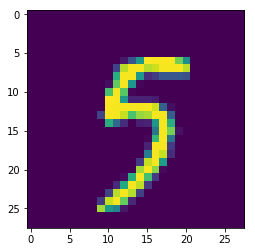

In [7]:
i = 420
plt.imshow(train_input[i, 0, :, :])
print(train_target[i].item())

## 1) LeNet F

In [8]:
train_dataset = (train_input, train_target)
test_dataset = (test_input, test_target)

in_channels = train_input.shape[1]
out_channels = 10

In [9]:
#debug_layers_dims(LeNet_gen(), train_input.shape)

In [10]:
target_classes = np.array(train_target.tolist())
unique, counts = np.unique(target_classes, return_counts=True)

print(dict(zip(unique, counts)))
crossEntropyClassesWeigths = Tensor(counts/len(target_classes))

{0: 97, 1: 116, 2: 99, 3: 93, 4: 105, 5: 92, 6: 94, 7: 117, 8: 87, 9: 100}


******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.02215846           0.247      0.00211227           0.307
10                   0.00298656           0.921      0.00052257           0.844
20                   0.00118625           0.967      0.00027482           0.908
30                   0.00041886           0.996      0.00021881           0.917
39                   0.00020069           1.000      0.00019959           0.925
*******************************************************************************


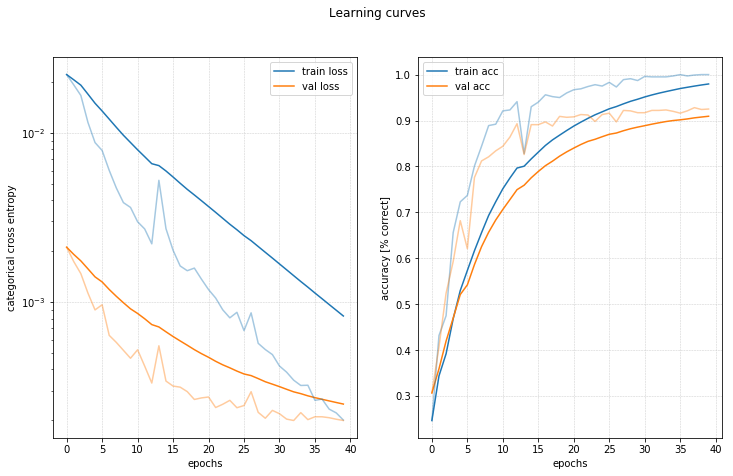

In [22]:
crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

net = LeNet()
loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.05

mt = ModelTrainer(net, loss_fun, optim.SGD(net.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(train_dataset, test_dataset, epochs=40, batch_size=100, verbose=10)
mt.plot_training("Learning curves")

## 2) Net G

In [23]:
(g_train_input, g_train_target), (g_test_input, g_test_target) = \
generate_dataset_g(net, train_dataset, test_dataset, [net.conv2], ['conv 2'], split=0.5, full=False)

g_train_target = g_train_target.long()
g_test_target = g_test_target.long()

g_train_dataset = (g_train_input, g_train_target)
g_test_dataset = (g_test_input, g_test_target)  

In [24]:
g_train_target.shape

torch.Size([1000])

In [25]:
size_input_vector = g_train_dataset[0].shape[2]
print("size of layer vector :", size_input_vector)

size of layer vector : 1024


In [26]:
target_classes = np.array(g_train_dataset[1].tolist())
unique, counts = np.unique(target_classes, return_counts=True)

print(dict(zip(unique, counts)))
crossEntropyClassesWeigths = Tensor(counts/len(target_classes))

{0: 500, 1: 500}


In [47]:
b = batch_fun(1000, 52)
idxs = torch.randperm(1000)
idxs.split(b)

(tensor([938, 103, 473, 495, 564,  35, 206, 286, 839, 240, 509, 230, 515, 281,
         991, 822, 977, 929, 601, 355, 471, 614, 299,  32, 597, 444, 389, 352,
         290, 874, 335, 351, 812, 783, 619,  82, 510, 632, 184,  94, 702, 975,
         689, 316,  55,  85,   3, 238, 409, 323, 793, 456, 104, 496,  77,  24,
         154, 560, 979,  19,  88,  42, 679, 439, 944,  72, 903, 690, 280, 318,
         798, 219, 130,  97, 844, 710, 966, 276, 173, 319, 523, 470, 404, 462,
         861, 460, 374, 721, 133, 980, 369, 581, 755, 825, 984, 694, 446, 870,
          49, 555, 501, 291, 320, 958, 774, 849, 660,  62,  17, 243, 636, 687,
         578, 995, 494,  43, 402, 807, 208, 659, 942, 129, 100, 746, 729, 745,
         337, 953, 429, 964, 599, 626, 930, 132, 828, 465, 875, 237, 529, 790,
         249, 834, 126, 777,  75, 333,  68, 521, 481,  69, 298, 427, 763, 645,
         821, 653, 634,   2, 638, 157,  78, 873, 762, 613, 228, 778, 423, 348,
         672, 474,  65, 633, 701,  95, 295, 604, 941

In [57]:
1000 - (60 // 25) * 25

950

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.00071070           0.493      0.00156066           0.671
10                   0.00069367           0.603      0.00078354           0.549
20                   0.00065054           0.636      0.00061835           0.677
30                   0.00064084           0.629      0.00060575           0.665
40                   0.00124170           0.656      0.00059660           0.685
50                   0.00121189           0.671      0.00060497           0.678
60                   0.00115944           0.670      0.00060415           0.684
70                   0.00112085           0.689      0.00061117           0.683
80                   0.00110955           0.694      0.00060985           0.677
90                   0.00103405           0.715      0.00062430           0.685
100                  0.00104882         

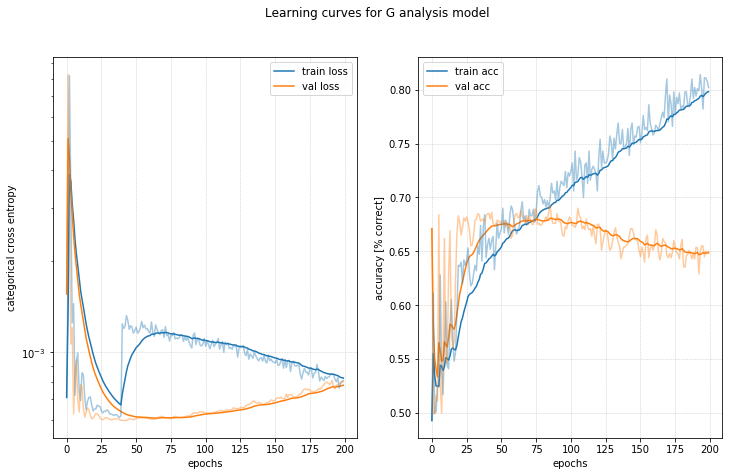

In [63]:
modelG = denseG(size_input_vector)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)
batch_cap = 40
#batch_fun = lambda x, y: x // (y // batch_cap + 1) #x: batch_size, y: epoch
batch_fun = lambda x, y: x - 2*(y // batch_cap) * batch_cap

loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.01

mt = ModelTrainer(modelG, loss_fun, optim.Adamax(modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun, batch_fun)
hist = mt.fit(g_train_dataset, g_test_dataset, epochs=200, batch_size=1000, verbose=10)
mt.plot_training("Learning curves for G analysis model")